In [68]:
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from langchain_tavily.tavily_search import TavilySearch
from typing import TypedDict, Literal
from dotenv import load_dotenv
from langgraph_runtime_inmem.checkpoint import InMemorySaver
from langgraph.types import interrupt, Command


load_dotenv()


class State(TypedDict):
    user_msg: str | None
    summary: str | None
    is_approved: bool | None
    llm_output: str | None


def human_approval(state: State) -> Command[Literal["print_summary", "assistant"]]:
    return interrupt(
        {
            "question": "Do you accept the summary?",
            "llm_output": state["summary"],
        }
    )

llm = init_chat_model("openai:gpt-4.1")

search_tool = TavilySearch(max_results=3)

sys_msg = SystemMessage(content="""
You are a helpful assistant tasked with summarizing websearch results based on the user search query.
* Given the web search results based on the user search query summarize it and present in a readable format.
""")

user_prompt = """
given the following web input:
{user_input}
these are the web results:
{web_results}
"""

# Node
def assistant(state: State):
    user_message = state["user_msg"]
    results = search_tool.invoke(user_message)
    web_result_content = "\n".join([r["content"] for r in results.get("results", [])])
    user_msg = HumanMessage(content=user_prompt.format(user_input=user_message, web_results=web_result_content))
    return {"summary": llm.invoke([sys_msg] + [user_msg])}

# Node
def print_summary(state: State):
    summary = state["summary"]
    print("\n=== SUMMARY ===\n")
    print(summary)
    print("\n===============")

graph_builder = StateGraph(State)

graph_builder.add_node("assistant", assistant)
graph_builder.add_node("human_approval", human_approval)
graph_builder.add_node("print_summary", print_summary)

graph_builder.add_edge(START, "assistant")
graph_builder.add_edge("assistant", "human_approval")

graph_builder.add_edge("human_approval", "print_summary")
graph_builder.add_conditional_edges(
    "human_approval",
    lambda user_input: "print_summary" if user_input else "assistant"
)
graph_builder.add_edge("print_summary", END)

checkpointer = InMemorySaver()

graph = graph_builder.compile(checkpointer=checkpointer)


In [69]:
thread_config = {"configurable": {"thread_id": "summarization_1"}}

resp = graph.invoke({"user_msg": "whats happening in Ukraine now?"}, config=thread_config)

In [64]:
print(resp['summary'].content)

Here’s a summary of the latest developments in Ukraine based on your web search results:

- Russia has launched new attacks on Ukraine’s Zaporizhia region, resulting in at least one death and 28 wounded, including children.
- Ukrainian forces have responded by striking Russian oil refineries.
- There have been multiple explosions in western Ukrainian cities due to a large-scale drone attack by Russia overnight.
- The situation remains very active, with ongoing and escalating attacks as the war continues.

Overall, the region is experiencing intensified fighting, with both sides carrying out strikes—Russia on Ukrainian cities and Ukraine targeting Russian infrastructure.


In [72]:
def run_cli():
    thread_config = {"configurable": {"thread_id": "summarization_1"}}
    query = input("Enter your search query: ")
    state = {"user_msg": query}

    # initial run
    for event in graph.stream(state, config=thread_config):
        for node, value in event.items():
            if node == "human_approval":
                print("\n--- SUMMARY DRAFT ---\n")
                print(value["llm_output"])
                print("\n---------------------\n")

                # ask human
                while True:
                    choice = input("Do you approve? (y/n): ").strip().lower()
                    if choice in ("y", "n"):
                        break

                approved = choice == "y"

                # resume graph
                for resumed in graph.resume(approved, name="human_approval"):
                    pass

run_cli()


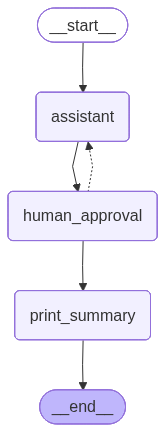

In [73]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass